# Initial EDA - Samsung Automating Explainability in Healthcare

*Data lineage:*

- This project is based on the data used in the following paper:

Aubreville, M., Bertram, C.A., Donovan, T.A. et al. A completely annotated whole slide image dataset of canine breast cancer to aid human breast cancer research. Sci Data 7, 417 (2020). https://doi.org/10.1038/s41597-020-00756-z

- Whole Slide Image (WSI) dataset is available in figshare site:

Aubreville, M. et al. Dogs as model for human breast cancer - a completely annotated whole slide image dataset. figshare https://doi.org/10.6084/m9.figshare.c.4951281 (2020).

- Annotated database associated with the dataset:

https://github.com/DeepPathology/MITOS_WSI_CMC/tree/master/databases



*Abbreviations:*

- MEL - manually expert labelled

- ODAEL - object-detection augmented and expert labeled 

- CODAEL - clustering- and object detection augmented manually expert labelled

In [104]:
from SlideRunner.dataAccess.database import Database
import SlideRunner.dataAccess.database
import os
import numpy as np
import pandas as pd
import cv2
import sqlite3

from openslide import open_slide
import openslide
from PIL import Image
from matplotlib import pyplot as plt

from pathlib import Path

The dataset which consists of 21 anonymized WSIs in Aperio SVS file format, is publicly available on figshare (See top of the notebook for reference).

In [105]:
# Whole Slide Images:

WSI_Slides = ['deb768e5efb9d1dcbc13.svs',
              'd37ab62158945f22deed.svs',
              '022857018aa597374b6c.svs',
              '69a02453620ade0edefd.svs',
              'a8773be388e12df89edd.svs',
              'c4b95da36e32993289cb.svs',
              '3d3d04eca056556b0b26.svs',
              'd0423ef9a648bb66a763.svs',
              '50cf88e9a33df0c0c8f9.svs',
              '084383c18b9060880e82.svs',
              '4eee7b944ad5e46c60ce.svs',
              '2191a7aa287ce1d5dbc0.svs',
              '13528f1921d4f1f15511.svs',
              '2d56d1902ca533a5b509.svs',
              '460906c0b1fe17ea5354.svs',
              'da18e7b9846e9d38034c.svs',
              '72c93e042d0171a61012.svs',
              'b1bdee8e5e3372174619.svs',
              'fa4959e484beec77543b.svs',
              'e09512d530d933e436d5.svs',
              'd7a8af121d7d4f3fbf01.svs']                  

In [106]:
print('Total number of WSI files is '+str(len(WSI_Slides)))

Total number of WSI files is 21


Along with the WSI, the authors of the paper provided cell annotations in a SQLite3 database. For each annotation, this database provides:

- WSI of the annotation

- Absolute center coordinates (x,y) on the WSI

- Class labels, assigned by all experts and the final agreed class. Each annotation label is included in this, resulting in at least two labels (in the case of initial agreement and no further modifications), one by each expert. The unique numeric identifier of each label furthermore represents the order in which the labels were added to the database.

In [107]:
# Cell annotations in a SQLite3 database:

Databases = ['MITOS_WSI_CMC_COADEL_TR.sqlite',
            'MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite',
            'MITOS_WSI_CMC_MEL.sqlite',
            'MITOS_WSI_CMC_ODAEL_TR.sqlite',
            'TUPAC.sqlite',
            'TUPAC_alternativeLabels_augmented_training.sqlite',
            'TUPAC_stitched.sqlite']

Path_DB = Path('./databases/')
Path_WSI = Path('/Volumes/DA_HDD/CAPSTONE/WSI/')

# Let's Explore An Example WSI 

This section is going to explore on example of the dataset.

In [108]:
slide = open_slide(Path_WSI/"deb768e5efb9d1dcbc13.svs")

slide_props = slide.properties

In [109]:
print(slide_props)

<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': '130.133.91.37', 'aperio.Date': '10/19/18', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'deb768e5efb9d1dcbc13', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '50216', 'aperio.Left': '18.268524', 'aperio.LineAreaXOffset': '0.003040', 'aperio.LineAreaYOffset': '-0.011652', 'aperio.LineCameraSkew': '-0.000450', 'aperio.MPP': '0.2533', 'aperio.OriginalHeight': '76526', 'aperio.OriginalWidth': '106720', 'aperio.ScanScope ID': 'VETWE12MIC', 'aperio.SessonMode': 'NR', 'aperio.StripeWidth': '1840', 'aperio.Time': '11:34:44', 'aperio.Time Zone': 'GMT+02:00', 'aperio.Title': 'deb768e5efb9d1dcbc13', 'aperio.Top': '22.445175', 'aperio.User': 'ddc02af9-3dd4-4cc3-93d5-8999b0702469', 'openslide.comment': 'Aperio Image Library v12.0.15 ..106720x76526 [0,100 104399x76426] (240x240) J2K/KDU Q=70|AppMag = 40|StripeWidth = 1840|ScanScope

In [110]:
print('Vendor is '+slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x']) #mpp - microns per pixel
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y']) #mpp - microns per pixel

Vendor is aperio
Pixel size of X in um is: 0.25330000000000003
Pixel size of Y in um is: 0.25330000000000003


In [111]:
#Objective used to capture the image
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective) # this image is collected at power 40x

The objective power is:  40.0


In [112]:
# Get slide dims at each level. Whole slide images store information as a pyramid at various levels
dims = slide.level_dimensions

num_levels = len(dims)
print("Number of levels in this image are:", num_levels)
print("Dimensions of various levels in this image are:", dims)

Number of levels in this image are: 4
Dimensions of various levels in this image are: ((104399, 76426), (26099, 19106), (6524, 4776), (3262, 2388))


In [113]:
# By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors) 

Each level is downsampled by an amount of:  (1.0, 4.000109813045606, 16.00219650264402, 32.00439300528804)


In [114]:
# Get slide dimensions for the level 0 - max resolution level (level 0 because it is a pyramid)
slide_dims = slide.dimensions
print(slide_dims)

(104399, 76426)


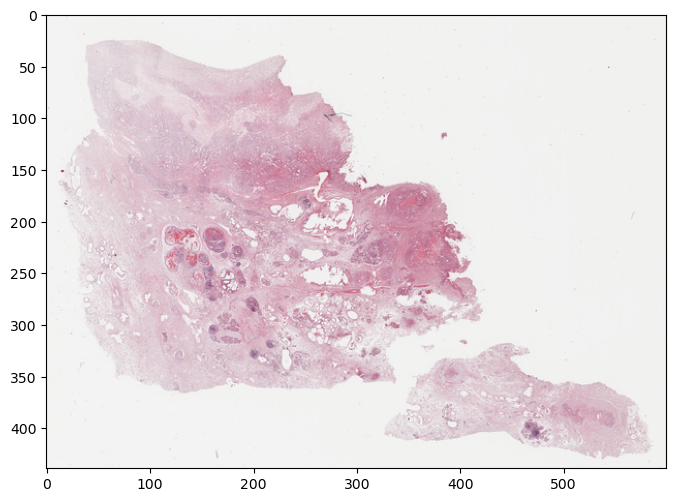

In [115]:
# Get a thumbnail of the image and visualize - this is a re-sized image of the whole slide image
slide_thumb_600 = slide.get_thumbnail(size=(600, 600)) 
slide_thumb_600.show()

# Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np) 

# Let's Explore Annotations Database 

In [116]:
print('Database name: '+str(Databases[0]))

Database name: MITOS_WSI_CMC_COADEL_TR.sqlite


In [117]:
DB = Database()
DB.open(str(Path_DB/Databases[0]));

slideid = DB.findSlideWithFilename(str(WSI_Slides[0]),'') # look up slide in database
DB.loadIntoMemory(slideid)

In [118]:
for anno in DB.annotations.keys():
    print(anno,':',DB.annotations[anno])

24634 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd78270460>
24635 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd7a695130>
24636 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd7cef2760>
24637 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c8190>
24638 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c8100>
24640 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c8040>
24641 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c80a0>
24642 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c81f0>
24643 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c8070>
24644 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c8130>
24645 : <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7fcd784c82b0>
24646 : <SlideRunner.dataAccess.annotations.spotAnnotation object

In [119]:
print('Total number of annotations in this database:  '+ str(len(DB.annotations)))

Total number of annotations in this database:  569


In [120]:
# Coorinates of this particular annotation
DB.annotations[24634].coordinates 

array([[11736,  6686],
       [11786,  6736]])

In [121]:
# This is the agreed class by all experts:
DB.annotations[24634].agreedClass

2

In [122]:
# For each object, database provides a human readable description (to be used in classification and for report),
# for example:
DB.annotations[24634].getDescription(DB)

[['Position', 'x1=11761, y1=6711'],
 ['Anno 1', 'Mitotic figure (Christof)'],
 ['Anno 2', 'Mitotic figure (Robert)'],
 ['Anno 3', 'Mitotic figure (Christof and Robert)'],
 ['Agreed Class', 'Mitotic figure']]

In [123]:
# For each object, database provides a human readable description (to be used in classification and for report),
# for example:
DB.annotations[24653].getDescription(DB)

[['Position', 'x1=21578, y1=11504'],
 ['Anno 1', 'Mitotic cell look-alike (Christof)'],
 ['Anno 2', 'Mitotic cell look-alike (Robert)'],
 ['Anno 3', 'Mitotic cell look-alike (Christof and Robert)'],
 ['Agreed Class', 'Mitotic cell look-alike']]

In [124]:
# X, y coordinates of the annotation and the radius of the annotataion, for example:
DB.annotations[24653].x1, DB.annotations[24653].y1, DB.annotations[24653].r

(21578, 11504, 25)

### For information:
*read_region(location, level, size)* -- Return an RGBA Image containing the contents of the specified region.

Parameters:

location (tuple) – (x, y) tuple giving the top left pixel in the level 0 reference frame

level (int) – the level number

size (tuple) – (width, height) tuple giving the region size

Agreed Class is Mitotic cell look-alike


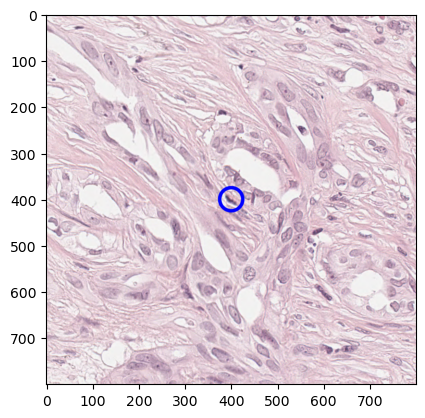

In [125]:
# Show an example image with a annotation

LeftUpper = (21578-400, 11504-400) # this location is top left pixel which is equal to location of 
# annotation - half of the region size defined below

img = np.array(slide.read_region(LeftUpper, 0, [800,800]))

from SlideRunner.dataAccess.annotations import ViewingProfile
DB.annotations[24653].draw(image=img, leftUpper=LeftUpper, zoomLevel=1., thickness=5, vp=ViewingProfile())
plt.imshow(img)

print('Agreed Class is '+str(DB.annotations[24653].getDescription(DB)[4][1]))

# Let's Explore the Structure of Database

In [126]:
CON_COADEL_TR = sqlite3.connect(str(Path_DB/Databases[0]))

Table_Names_COADEL_TR=pd.read_sql_query('SELECT name from sqlite_master where type= "table";', con=CON_COADEL_TR)
Table_Names_COADEL_TR

,name
0,Annotations
1,sqlite_sequence
2,Annotations_coordinates
3,Annotations_label
4,Classes
5,Log
6,Persons
7,Slides


COADEL_TR database has 8 tables with names shown above.

In [127]:
COADEL_TR_Anno= pd.read_sql_query('SELECT * FROM Annotations', con=CON_COADEL_TR)
COADEL_TR_SQL_Seq= pd.read_sql_query('SELECT * FROM sqlite_sequence', con=CON_COADEL_TR)
COADEL_TR_Anno_Coor= pd.read_sql_query('SELECT * FROM Annotations_coordinates', con=CON_COADEL_TR)
COADEL_TR_Anno_label= pd.read_sql_query('SELECT * FROM Annotations_label', con=CON_COADEL_TR)
COADEL_TR_Classes= pd.read_sql_query('SELECT * FROM Classes', con=CON_COADEL_TR)
COADEL_TR_Log= pd.read_sql_query('SELECT * FROM Log', con=CON_COADEL_TR)
COADEL_TR_Persons= pd.read_sql_query('SELECT * FROM Persons', con=CON_COADEL_TR)
COADEL_TR_Slides= pd.read_sql_query('SELECT * FROM Slides', con=CON_COADEL_TR)

In [128]:
COADEL_TR_Classes

,uid,name,color
0,1,Mitotic cell look-alike,#0130d2
1,2,Mitotic figure,#22ff0d
2,4,Tumor region,#ff0000
3,5,Exclude from tumor region,#7fc4ae


In [164]:
COADEL_TR_Anno['agreedClass'].count().

SyntaxError: invalid syntax (3569420004.py, line 1)

In [156]:
for i in range(len(COADEL_TR_Classes)):
    class_name = str(COADEL_TR_Classes[i])
    aggregate_class = COADEL_TR_Anno[COADEL_TR_Anno['agreedClass']==COADEL_TR_Classes[i]].count()
    print('Total number of '++)


uid             46
slide           46
type            46
agreedClass     46
guid            46
deleted         46
lastModified    46
description     46
clickable       46
dtype: int64

In [129]:
CON_MEL = sqlite3.connect(str(Path_DB/Databases[2]))

Table_Names_MEL=pd.read_sql_query('SELECT name from sqlite_master where type= "table";', con=CON_MEL)
Table_Names_MEL

,name
0,Annotations_label
1,sqlite_sequence
2,Annotations_coordinates
3,Annotations
4,Classes
5,Persons
6,Slides
7,Log


In [130]:
MEL_Anno= pd.read_sql_query('SELECT * FROM Annotations', con=CON_MEL)
MEL_SQL_Seq= pd.read_sql_query('SELECT * FROM sqlite_sequence', con=CON_MEL)
MEL_Anno_Coor= pd.read_sql_query('SELECT * FROM Annotations_coordinates', con=CON_MEL)
MEL_Anno_label= pd.read_sql_query('SELECT * FROM Annotations_label', con=CON_MEL)
MEL_Classes= pd.read_sql_query('SELECT * FROM Classes', con=CON_MEL)
MEL_Log= pd.read_sql_query('SELECT * FROM Log', con=CON_MEL)
MEL_Persons= pd.read_sql_query('SELECT * FROM Persons', con=CON_MEL)
MEL_Slides= pd.read_sql_query('SELECT * FROM Slides', con=CON_MEL)

In [131]:
MEL_Classes

,uid,name,color
0,1,Mitotic cell look-alike,#21ff22
1,2,Mitotic figure,#0000ef


In [132]:
Databases[5]

'TUPAC_alternativeLabels_augmented_training.sqlite'

In [133]:
CON_TUPAC = sqlite3.connect(str(Path_DB/Databases[5]))

Table_Names_TUPAC=pd.read_sql_query('SELECT name from sqlite_master where type= "table";', con=CON_TUPAC)
Table_Names_TUPAC

,name
0,Annotations_label
1,sqlite_sequence
2,Annotations_coordinates
3,Annotations
4,Classes
5,Persons
6,Slides
7,Log


In [134]:
TUPAC_Anno= pd.read_sql_query('SELECT * FROM Annotations', con=CON_TUPAC)
TUPAC_SQL_Seq= pd.read_sql_query('SELECT * FROM sqlite_sequence', con=CON_TUPAC)
TUPAC_Anno_Coor= pd.read_sql_query('SELECT * FROM Annotations_coordinates', con=CON_TUPAC)
TUPAC_Anno_label= pd.read_sql_query('SELECT * FROM Annotations_label', con=CON_TUPAC)
TUPAC_Classes= pd.read_sql_query('SELECT * FROM Classes', con=CON_TUPAC)
TUPAC_Log= pd.read_sql_query('SELECT * FROM Log', con=CON_TUPAC)
TUPAC_Persons= pd.read_sql_query('SELECT * FROM Persons', con=CON_TUPAC)
TUPAC_Slides= pd.read_sql_query('SELECT * FROM Slides', con=CON_TUPAC)

In [135]:
TUPAC_Classes

,uid,name,color
0,1,Mitose,#00aa00
1,2,Hard negative,#ffff00


# Explore Later - Combine Databases

We will keep exploring the database, explore combining databases to generate summary of the classes. We will revisit the paper and revise/eliminate unnecessary data from the databases.

In [136]:
DB = Database().open(Path_DB/'MITOS_WSI_CMC_ODAEL_TR.sqlite')
DB.execute('ATTACH `./databases/MITOS_WSI_CMC_MEL.sqlite` as MEL;')
DB.execute('ATTACH `./databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite` as CODAEL;')

ODAEL = DB.execute("""
SELECT * FROM (
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM 
(SELECT COUNT(*) as MitoticFigureLookalikes, slide from Annotations where agreedClass==1 group by slide) as cls1
LEFT JOIN (SELECT COUNT(*) as MitoticFigures, slide from Annotations where agreedClass==2 group by slide) as cls2 on cls2.slide == cls1.slide
LEFT JOIN Slides on Slides.uid == cls2.slide order by mitoticFigures) as ODAEL
LEFT JOIN 
(
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM (
SELECT COUNT(*) as MitoticFigures, slide from MEL.Annotations where agreedClass==2 group by slide) as cls2
LEFT JOIN (SELECT COUNT(*) as MitoticFigureLookalikes, slide from MEL.Annotations where agreedClass==1 group by slide) as cls1 on cls1.slide == cls2.slide
LEFT JOIN MEL.Slides on Slides.uid == cls2.slide order by mitoticFigures
) as MEL on MEL.filename == ODAEL.filename
LEFT JOIN 
(
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM 
(SELECT COUNT(*) as MitoticFigureLookalikes, slide from CODAEL.Annotations where agreedClass==1 group by slide) as cls1
LEFT JOIN (SELECT COUNT(*) as MitoticFigures, slide from CODAEL.Annotations where agreedClass==2 group by slide) as cls2 on cls2.slide == cls1.slide
LEFT JOIN MEL.Slides on Slides.uid == cls2.slide order by mitoticFigures
) as CODAEL on CODAEL.filename == ODAEL.filename order by CODAEL.mitoticFigures


""").fetchall()

In [137]:
DB.execute("""SELECT COUNT(*) as MitoticFigureLookalikes, slide from Annotations where agreedClass==7 group by slide""").fetchall()

[]

In [183]:
DB

In [179]:
CON_DB= sqlite3.connect(str(DB))

Table_Names_DB=pd.read_sql_query('SELECT name from sqlite_master where type= "table";', con=CON_DB)
Table_Names_DB.head()

,name


In [138]:
test_slides = ['14','18','3','22','10','15','21']

In [139]:
dbTumor = Database()

dbTumor.open('./databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite')
totalarea = 0
totalmit = 0
totalnonmit = 0
totalmit_mel, totalnonmit_mel = 0,0
totalmit_odael, totalnonmit_odael = 0,0
for idx, (filename, mitA, nonmitA, _, mit,nonmit, _,  mitC,nonmitC) in enumerate(ODAEL):

    dbTSlide = dbTumor.findSlideWithFilename(os.path.basename(filename), slidepath='')
    dbTumor.loadIntoMemory(dbTSlide)
    
    slide = openslide.open_slide(Path_WSI/filename)


    positiveId = dbTumor.findClassidOfClass('Tumor region')[0][0]
    import matplotlib.path as p

    micronsPerPixel = slide.properties[openslide.PROPERTY_NAME_MPP_X]
    mpp_scaled = float(slide.level_downsamples[-1]) * float(micronsPerPixel)  

    slideActiveMap = np.zeros((slide.level_dimensions[-1][::-1]))
    ds = slide.level_downsamples[-1]
    for anno in dbTumor.annotations.keys():
        if (dbTumor.annotations[anno].agreedLabel()==positiveId) and (type(dbTumor.annotations[anno]) == type(dbTumor.annotations[anno]) == SlideRunner.dataAccess.annotations.polygonAnnotation):
            co = dbTumor.annotations[anno].coordinates
            p3 = np.int32([np.asarray(co)/ds])
            cv2.fillPoly(slideActiveMap, p3,color=[255] )

    for anno in dbTumor.annotations.keys():
        if not (dbTumor.annotations[anno].agreedLabel()==positiveId) and (type(dbTumor.annotations[anno]) == type(dbTumor.annotations[anno]) == SlideRunner.dataAccess.annotations.polygonAnnotation):
            co = dbTumor.annotations[anno].coordinates
            p3 = np.int32([np.asarray(co)/ds])
            cv2.fillPoly(slideActiveMap, p3,color=[0] )
    mm2 = np.sum(slideActiveMap>0)*mpp_scaled*mpp_scaled/1E6
    totalarea += mm2
    totalmit += mitC
    totalnonmit += nonmitC
    
    totalmit_mel, totalnonmit_mel = totalmit_mel+mit, totalnonmit_mel+nonmit
    totalmit_odael, totalnonmit_odael = totalmit_odael+mitA, totalnonmit_odael+nonmitA
    
    fname = filename.replace('_','\\_')
    print(f"{idx+1} & {fname} & {mm2:.2f}\,$\\mathrm"+"{mm2}"+f"^2$ & {mit:,d} / {mitA:,d} / {mitC:,d} & {nonmit:,d} / {nonmitA:,d} / {nonmitC:,d} & {'test' if str(dbTSlide) in test_slides else 'train'} \\\\ ")
    

1 & 4eee7b944ad5e46c60ce.svs & 66.06\,$\mathrm{mm2}^2$ & 47 / 61 / 64 & 114 / 196 / 193 & test \\ 
2 & a8773be388e12df89edd.svs & 37.01\,$\mathrm{mm2}^2$ & 64 / 71 / 74 & 204 / 591 / 588 & train \\ 
3 & deb768e5efb9d1dcbc13.svs & 187.43\,$\mathrm{mm2}^2$ & 92 / 96 / 84 & 287 / 472 / 484 & train \\ 
4 & e09512d530d933e436d5.svs & 214.97\,$\mathrm{mm2}^2$ & 87 / 98 / 102 & 602 / 742 / 738 & test \\ 
5 & 72c93e042d0171a61012.svs & 26.29\,$\mathrm{mm2}^2$ & 130 / 151 / 140 & 375 / 680 / 691 & train \\ 
6 & 2d56d1902ca533a5b509.svs & 49.32\,$\mathrm{mm2}^2$ & 139 / 155 / 153 & 228 / 365 / 367 & test \\ 
7 & 084383c18b9060880e82.svs & 41.71\,$\mathrm{mm2}^2$ & 157 / 173 / 160 & 404 / 547 / 560 & train \\ 
8 & da18e7b9846e9d38034c.svs & 253.10\,$\mathrm{mm2}^2$ & 187 / 210 / 211 & 991 / 1,354 / 1,353 & train \\ 
9 & 13528f1921d4f1f15511.svs & 339.93\,$\mathrm{mm2}^2$ & 283 / 301 / 292 & 963 / 1,127 / 1,136 & test \\ 
10 & d0423ef9a648bb66a763.svs & 273.88\,$\mathrm{mm2}^2$ & 378 / 411 / 354 &

In [140]:
totalnonmit_mel, totalnonmit_odael, totalnonmit

(26526, 36135, 36379)

In [141]:
totalmit_mel, totalmit_odael, totalmit

(13342, 14151, 13907)

In [142]:
print('Total area: ',totalarea,'mm^2')
print('mitotic figures in CODAEL data set',totalmit)
print('nonmitotic figures in CODAEL data set',totalnonmit)

Total area:  4360.07788915561 mm^2
mitotic figures in CODAEL data set 13907
nonmitotic figures in CODAEL data set 36379
